# **4.다양한 알고리즘과 시각화**

## 사전준비

### 0.1 라이브러리 

In [ ]:
# 0.1.1 colab에는 mlxtend 가 설치 되어 있으나 버전이 낮다. 업그레이드 한다. 
!pip install mlxtend -U

In [ ]:
# 0.1.2 pyECLAT 을 설치
! pip install pyECLAT

In [ ]:
# 0.1.3 수업에 필요한 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# mlxtend 라이브러리 import
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# pyECLAT 라이브러리 import
from pyECLAT import ECLAT

# 네트워크 그래프  import
import networkx as nx

### 0.2 Grocery 데이터 준비

In [ ]:
# 0.2 grocery 데이터를 읽어 들이고 분석에 사용할 수 있는 형태로 가공한다. 
# grocery_csv : 트랜잭션별 구매항목 목록 
# grocery_tr  : 트랜잭션 x 항목 형태집계표 형태

# grocery 거래정보 : 9865 트랜잭션,   169개 상품 항목
# 최소지지도 0.02에서 122개 빈발항목 생성
# 최소지지도 0.02, 최소신뢰도 0.3에서 34개 규칙 생성

 
# grocery 데이터를 읽어 들인다.  
grocery_csv = pd.read_csv('https://github.com/sagelab4data/association/blob/main/groceries.csv?raw=true', 
                          header = None)

# grocery 데이터를 apyori 라이브러리에서 사용 할 수 있는 형태인 리스트 형태로 변환한다. 
grocery_list = [ row_series.dropna().to_list() for idx, row_series in grocery_csv.iterrows()]

# 집계표 형태로 변환
te = TransactionEncoder()
te_ary = te.fit(grocery_list).transform(grocery_list)
grocery_tr = pd.DataFrame(te_ary, columns = te.columns_)

print (f'grocery_csv shape :{grocery_csv.shape}, grocery_tr shape : {grocery_tr.shape}')

#### grocery_csv

In [ ]:
grocery_csv.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### grocery_tr

In [ ]:
grocery_tr.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


### 0.3 Online Retail 데이터 준비

In [ ]:
# 0.3 online 데이터를 읽어 들이고 분석에 사용할 수 있는 형태로 가공한다. 
# online : 정규형화된 형태의 부가 정보를 보유한 원천 데이터 (long format 541,909행)
# online_tr  : 트랜잭션 x 항목 형태집계표 형태 (클랜징 후)

# online 거래 정보: 20,133 트랜잭션,   4,064개 상품 항목
# 최소지지도 0.01에서 1,853개 빈발항목 생성
# 최소지지도 0.01, 최소신뢰도 0.6에서 498개 규칙 생성

 
# gronlineocery 데이터를 읽어 들인다.  
gitpath ='https://github.com/sagelab4data/association/blob/main/Online%20Retail.xlsx?raw=true'
online = pd.read_excel(gitpath)

# online클랜징 
online_tmp = online.copy()  # 슬라이스를 사용하지 않기 위해 복제본 생성
online_tmp['Description'] = online_tmp['Description'].str.strip() # Description 앞뒤 공백제거

cleansing_bool = (online.InvoiceNo.astype('str').str.isnumeric()) & \
                  (online_tmp.Description.notnull()) &\
                  (online_tmp.Quantity > 0 )   # 클랜징 규칙생성           

online_tmp = online_tmp[cleansing_bool]  # online_tmp 필터링

# 집계표 형태로 변환 (pivot_table 이용)
def isExist(s) :
  return True if s.count() > 0 else False

online_tr =  online_tmp.pivot_table(values = 'Quantity',
                                         index= 'InvoiceNo', 
                                         columns = 'Description',
                                         aggfunc = isExist  ).fillna(False)
online_tr.shape
print (f'online shape :{online.shape}, online_tr shape : {online_tr.shape}')

In [ ]:
online.head()

#### online_tr

In [ ]:
online_tr.head()

## 4.2 다양한 알고리즘 비교 

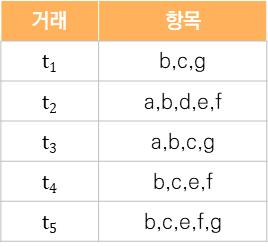

### 4.2.1 수업 예시 데이터 준비

#### sample

In [ ]:
# 4.2.1  수업 예시 데이터 준비 
# 4.2.1.1  데이터 입력
sample = [list('bcg'), list('abdef'), list('abcg'), list('bcef'), ***]
sample

[['b', 'c', 'g'],
 ['a', 'b', 'd', 'e', 'f'],
 ['a', 'b', 'c', 'g'],
 ['b', 'c', 'e', 'f'],
 ['b', 'c', 'e', 'f', 'g']]

#### sample_tr

In [ ]:
# 4.2.1.2 crosstab 집계표 형태로 변환
te = *** ()
sample_ary = te. *** (sample)
sample_tr = pd.DataFrame( ** , columns =  *** )
sample_tr

,a,b,c,d,e,f,g
0,False,True,True,False,False,False,True
1,True,True,False,True,True,True,False
2,True,True,True,False,False,False,True
3,False,True,True,False,True,True,False
4,False,True,True,False,True,True,True


#### sample_csv

In [ ]:
# 4.2.1.3 거래별 항목목록을 갖는 형태로 변환
sample_csv = pd.DataFrame( *** )
sample_csv

,0,1,2,3,4
0,b,c,g,None,None
1,a,b,d,e,f
2,a,b,c,g,None
3,b,c,e,f,None
4,b,c,e,f,g


### 4.2.2 Apriori

#### freq_its_sp_1

In [ ]:
# 4.2.2 apriori 를 이용하여 빈발 항목을 도출 
# 4.2.2.1  전체 빈발항목목록을 도출하기 위해 최소지지도는 0.1을 지정
freq_its_sp_1 = ***
freq_its_sp_1

* 61개 조합이 존재

#### freq_its_sp_4

In [ ]:
# 4.2.2.2  수업에서 사용한 최소지지도는 0.4를 지정
freq_its_sp_4 = apriori(sample_tr, min_support = 0.4, use_colnames = True)
print(freq_its_sp_4.shape)
freq_its_sp_4

* 수업에서 확인한 21건의 목록 (2개 항목이상 15건)을 확인

#### asso_rule_sp_4_7

In [ ]:
# 4.2.2.3  신뢰도 0.7을 지정하여 연관규칙 도출
asso_rule_sp_4_7 = association_rules(freq_its_sp_4, 
                                     metric = 'confidence', 
                                     min_threshold= 0.7)
asso_rule_sp_4_7.sort_values(['confidence','lift'],
                             ascending = False, 
                             inplace = True)
print(asso_rule_sp_4_7.shape)
asso_rule_sp_4_7

* 29건의 규칙 생성

### 4.2.3 Eclat 

In [ ]:
# 4.2.3 pyECLAT으로 Eclat 수행
#   Eclat,  mlxtend는 Eclat 알고리즘을 제공하지 않는다. pyECLAT을 사용한다. 
#   (mlxtend와 작동방식이 다르다.)
# 4.2.3.1 pyECLAT은 ECLAT 객체를 생성하여 분석을 수행하며, 
#   입력데이터는 거래별 항목을 갖는 csv 형태를 받는다. 

eclat_instance = ECLAT( *** , verbose = True)


In [ ]:
# 4.2.3.2  ECLAT 객체에서 분석을 위해 생성한 집계표
eclat_instance.df_bin

In [ ]:
# 4.2.3.3  ECLAT 객체에서 분석을 위해 생성한 항목 목록
eclat_instance.uniq_

#### get_ECLAT_supports

In [ ]:
# 4.2.3.4 지지도 0.4와 인수를 지정하여 실행
get_ECLAT_indexes, get_ECLAT_supports = \
          eclat_instance.fit(min_support=0.4,
                             min_combination=1,
                             max_combination=4,
                             separator=',',
                             verbose=True)


In [ ]:
# 4.2.3.5 조건을 충족하는 항목의 지지도
print(len(get_ECLAT_supports))
get_ECLAT_supports

In [ ]:
# 4.2.3.6 조건을 충족하는 항목의 Tid Set
get_ECLAT_indexes

### 4.2.4 FP-Growth

#### freq_its_sp_4_fp

In [ ]:
# 4.2.4  mlxtend 라이브러리의 fpgrowth로 빈발항목을 추출해본다.  최소지지도는 0.4를 지정
freq_its_sp_4_fp = fpgrowth(sample_tr, 
                            min_support = 0.4, 
                            use_colnames = True)
print(freq_its_sp_4_fp.shape)
freq_its_sp_4_fp

### 4.2.5 성능 비교 groccry (9865 x 169)

In [ ]:
# 4.2.5.1 Apriori on grocery, min_support = 0.02
%timeit apriori(grocery_tr, 0.02)

10 loops, best of 5: 132 ms per loop


In [ ]:
# 4.2.5.2 FP-Growth on grocery, min_support = 0.02
%timeit fpgrowth(grocery_tr, 0.02)

10 loops, best of 5: 172 ms per loop


* FP-Growth가 더 시간이 소요된다. 작은 규모에서는 트리를 생성하는 오버헤드로 Apriori 대비 성능이 떨어진다. 

### 4.2.6 성능 비교 online (20133 x 4064)

In [ ]:
# 4.2.6.1 Apriori는 메모리를 많이 사용한다.  
# 실행하지 말것!
# low_memory default는 False, 
# online_tr의 경우 기본 코랩 제공 메모리에서 최소지지도 0.013 부근에서 apriori 실행시 다운된다. asof 2022 summer

# apriori(online_tr, 0.01, low_memory = False)

In [ ]:
# 4.2.6.2 Apriori @ mlxtend
%timeit apriori(online_tr, 0.02, low_memory = True)

1 loop, best of 5: 10.8 s per loop


In [ ]:
# 4.2.6.3 fpgrowth @ mlxtend
%timeit fpgrowth(online_tr, 0.02)

1 loop, best of 5: 3.85 s per loop


* 데이터의 규모가 커지면 fpgrowth 의 성능이 더 좋은 것으로 나타난다. 

## 4.3 연관관계 시각화
- networkx 라이브러리는 네트워크 다이어그램을 작성하기 위한 라이브러리
- 본 실습에서는 DataFrame에서 네트워크를 생성하고, matplotlib으로 시각화 하는 과정을 수행한다. 
- .from_pandas_edgelist (df, source = , target =)


### 사전준비

In [ ]:
# 4.3.0.1 colab에는 mlxtend 가 설치 되어 있으나 버전이 낮다. 업그레이드 한다. 
!pip install mlxtend -U

In [ ]:
# 4.3.0.2 수업에 필요한 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# mlxtend 라이브러리 import
from mlxtend.frequent_patterns import apriori,  association_rules
from mlxtend.preprocessing import TransactionEncoder


# 네트워크 그래프  import
import networkx as nx

In [ ]:
# 4.3.0.3 수업 예시로 사용된 sample 데이터를 구성하고, 최소지지도 0.4, 최소신뢰도 0.7의 연관규칙을 생성한다. 

#sample 데이터 구성
sample = [list('bcg'), list('abdef'), list('abcg'), list('bcef'),list('bcefg')]
te = TransactionEncoder ()
sample_ary = te.fit_transform (sample)
sample_tr = pd.DataFrame( sample_ary , columns =  te.columns_)
sample_tr

# 빈발항목집합과 연관규칙 생성
freq_its_sp_4 = apriori(sample_tr, min_support = 0.4, use_colnames = True)
asso_rule_sp_4_7 = association_rules(freq_its_sp_4, 
                                     metric = 'confidence', 
                                     min_threshold= 0.7)

In [ ]:
# 4.3.0.4 grocery 데이터를 읽어 들이고 분석에 사용할 수 있는 형태로 가공한다. 
# grocery_csv : 트랜잭션별 구매항목 목록 
# grocery_tr  : 트랜잭션 x 항목 형태집계표 형태

# grocery 거래정보 : 9865 트랜잭션,   169개 상품 항목
# 최소지지도 0.02에서 122개 빈발항목 생성
# 최소지지도 0.02, 최소신뢰도 0.3에서 34개 규칙 생성

 
# grocery 데이터를 읽어 들인다.  
grocery_csv = pd.read_csv('https://github.com/sagelab4data/association/blob/main/groceries.csv?raw=true', 
                          header = None)

# grocery 데이터를 apyori 라이브러리에서 사용 할 수 있는 형태인 리스트 형태로 변환한다. 
grocery_list = [ row_series.dropna().to_list() for idx, row_series in grocery_csv.iterrows()]

# 집계표 형태로 변환
te = TransactionEncoder()
te_ary = te.fit(grocery_list).transform(grocery_list)
grocery_tr = pd.DataFrame(te_ary, columns = te.columns_)

print (f'grocery_csv shape :{grocery_csv.shape}, grocery_tr shape : {grocery_tr.shape}')

### 4.3.1 networkx import

In [ ]:
# 4.3.1 네트워크 도표로 표현하기 위한 라이브러리 import
import matplotlib.pyplot as plt
import networkx as nx

### 4.3.2 네트워크 그래프 출력(예시데이터)

In [ ]:
# 4.3.2 알고리즘 비교에서 사용한 sample 데이터의 지지도 0.4, 신뢰도 0.7 로 
#         도출된 연관 규칙을 시각화 한다. 
# 4.3.2.1 데이터 확인

print(asso_rule_sp_4_7.shape)
asso_rule_sp_4_7.tail()

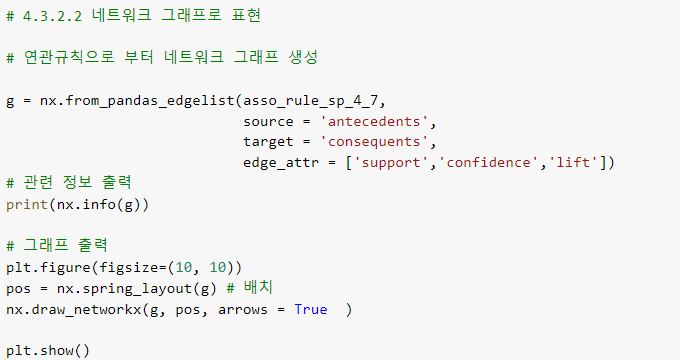

In [ ]:
# 4.3.2.2 네트워크 그래프로 표현

# 연관규칙으로 부터 네트워크 그래프 생성
#
g = nx.from_pandas_edgelist( *** , 
                            source = *** , 
                            target = *** 
                            edge_attr = ['support','confidence','lift'])
# 관련 정보 출력
print(nx.info(g))

# 그래프 출력
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(g) # 배치 
nx.*** ( ** , ** , arrows = True  )


plt.show()

### 4.3.3 네트워크 출력 함수화

In [ ]:
# 4.3.3 네트워크 다이어그램 반복 생성을 위한 함수화
# 4.3.3.1 함수 생성
def my_draw_nx (asso_rule_df, title = 'Network Graph', fontsize = 15,
                show_edgelabel = True) :

  import networkx as nx

  # antecedents,consequents 가 frozenset 이여서 레이블이 길다. 문자열로 변환
  nx_df = asso_rule_df.copy()
  nx_df['antecedents'] = nx_df['antecedents'].apply(lambda x : str(set(x)))
  nx_df['consequents'] = nx_df['consequents'].apply(lambda x : str(set(x)))

  # 연관규칙으로 부터 네트워크 그래프 생성

  g = nx.from_pandas_edgelist(nx_df, 
                              source = 'antecedents', 
                              target = 'consequents',
                              edge_attr =['support','confidence','lift']
                              )
  # 관련 정보 출력
  print(nx.info(g))

  #  node 크기 계산
  d1 = {  row.antecedents : row['antecedent support']  
          for ix, row in nx_df.iterrows()}
  d2 = {  row.consequents : row['consequent support']  
          for ix, row in nx_df.iterrows()}
  d1.update(d2)
  node_size = np.array([ np.sqrt(d1[k]) * 600 for k in list(g)])

  # 그래프 출력
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(g,  weight= 'confidence', seed=42)
  #pos = nx.spring_layout(g, k = 0.30, weight= 'confidence')

  nx.draw_networkx_labels(g,pos,font_size=fontsize, )
 
  nx.draw_networkx(g,pos,  node_color = 'green', 
                   with_labels = False,
                   alpha = 0.3 ,
                   arrows = True, arrowsize = fontsize,
                   node_size = node_size)

  if show_edgelabel : 
    edge_d = { (row.antecedents, row.consequents)  :f'{row.lift:.2f}' 
              for ix, row in nx_df.iterrows()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels = edge_d)
  
  plt.title(title) # 그래프 제목
  
  plt.show()

#### NG asso_rule_sp_4_7

In [ ]:
# 4.3.3.2 함수를 이용한 샘플데이터의 관계 그래프 출력
my_draw_nx( ***  ,title = *** )

### 4.3.4 예시데이터 시각화

In [ ]:
# 4.3.4 다양한 관계 규칙으로 그래프를 시도 (지지도를 0.5 이상으로 향상, 신뢰도 0.7)
# 4.3.4.1 간편하게 연관규칙을 도출하기 위해 apriori와 association_rules 일괄실행 함수화

def my_apri_asso (tr_df, min_sup=0.2, min_conf=0.5) :
  from mlxtend.frequent_patterns import apriori, association_rules
  
  # 빈발항목 생성
  freq_its = apriori (tr_df, 
                      min_support = min_sup, 
                      use_colnames = True)

  # 연관규칙 생성
  asso_rules = association_rules (freq_its, 
                                  metric= 'confidence', 
                                  min_threshold=min_conf)
  # 신뢰도, 향상도 내림차순 정렬
  asso_rules.sort_values(['confidence','lift'],
                         ascending = False, 
                         inplace = True)

  # 빈발항목 및 연관규칙 건수 출력
  print (f'frequent itemlist size : {freq_its.shape[0]},',
         f' association rule size : {asso_rules.shape[0]}')
  
 
  return asso_rules

#### NG asso_rule_sp_5_7

In [ ]:
# 4.3.4.2 데이터 생성 후 네트워크 그래프 출력 
#      sample_tr @ (지지도를 0.5 이상으로 향상, 신뢰도 0.7)
asso_rule_sp_5_7 = my_apri_asso( *** , min_sup= **, min_conf= ** )
my_draw_nx(asso_rule_sp_5_7, 'sample data @ ms 0.5 mc 0.7')

### 4.3.5 grocery 시각화

#### NG asso_rule_gr_02_3

In [ ]:
# 4.3.5 grocery 데이터의 연관규칙을 다양한 조건으로 시각화 하여 관찰한다. 

# 4.3.5.1 Hands_on에서 진행한 최소지지도 0.02, 신뢰도 0.3 연관규칙 생성
asso_rule_gr_02_3 = *** (grocery_tr, 0.02, 0.3)

frequent itemlist size : 122,  association rule size : 37


In [ ]:
# 4.3.5.2 네트워크그래프 생성
*** (asso_rule_gr_02_3 , 'Grocery @ ms 0.02 mc 0.3 N=37', fontsize = 12, 
           show_edgelabel=False)

#### NG asso_rule_gr_02_4

In [ ]:
# 4.3.5.3 그래프가 복잡하다. 최소지지도 0.02, 최소신뢰도를 0.4로 상향 조정하여 살펴본다. 
asso_rule_gr_02_4 = my_apri_asso(grocery_tr, min_sup = *** , min_conf = *** )
my_draw_nx ( *** ,'Grocery @ ms 0.02 mc 0.4 N=15', fontsize = 12,
            show_edgelabel = True)

#### NG asso_rule_gr_01_2_yogurt

In [ ]:
# 4.3.5.4 'yogurt' 와 관련된 관계가 궁금하다. 최소지지도 0.01, 최소신뢰도 0.2 에서 탐사해보자. 
asso_rule_gr_01_2 = my_apri_asso(grocery_tr, 0.01, 0.2)

filter = asso_rule_gr_01_2.antecedents.apply(lambda x :'yogurt' in x) | \
         asso_rule_gr_01_2.consequents.apply(lambda x :'yogurt' in x) 

asso_rule_gr_01_2_yogurt = asso_rule_gr_01_2[filter]

my_draw_nx (asso_rule_gr_01_2_yogurt,
            'Grocery Yogurt @ ms 0.01 mc 0.2 N=56', 
            fontsize = 12,
            show_edgelabel = True)

#### NG asso_rule_gr_01_2_2_yogurt (lift>=2)

In [ ]:
# 4.3.5.5 너무 복잡하다. lift >=2 조건을 추가해서 작성해보자. 
asso_rule_gr_01_2_2_yogurt = asso_rule_gr_01_2_yogurt[asso_rule_gr_01_2_yogurt.lift >= 2]

asso_rule_gr_01_2_2_yogurt
my_draw_nx (asso_rule_gr_01_2_2_yogurt,
            'Grocery Yogurt @ ms 0.01 mc 0.2 lift 2', 
            fontsize = 12,
            show_edgelabel = True)

In [ ]:
# 4.3.5.6 'sausage' 와 'beef'에 구매성향에 차이가 있을까?

filter_sausage = asso_rule_gr_01_2.antecedents.apply(lambda x : 'sausage' in x) | \
         asso_rule_gr_01_2.consequents.apply(lambda x : 'sausage' in x) 

filter_beef = asso_rule_gr_01_2.antecedents.apply(lambda x : 'beef' in x) | \
         asso_rule_gr_01_2.consequents.apply(lambda x : 'beef' in x) 

asso_rule_gr_01_2_sausage = asso_rule_gr_01_2[  *** ]
asso_rule_gr_01_2_beef = asso_rule_gr_01_2[ *** ]

asso_rule_gr_01_2_sausage.shape, asso_rule_gr_01_2_beef.shape

((7, 9), (5, 9))

#### NG asso_rule_gr_01_2_sausage

In [ ]:
#  4.3.5.7 'sausage' 그래프 출력
my_draw_nx (asso_rule_gr_01_2_sausage,
            'Grocery Sausage @ ms 0.01 mc 0.2 N=7', fontsize = 12)

#### NG asso_rule_gr_01_2_beef

In [ ]:
#  4.3.5.8 'beef' 그래프 출력
my_draw_nx (asso_rule_gr_01_2_beef,
            'Grocery Beef @ ms 0.01 mc 0.2 N=5', fontsize = 12)